In [1]:
! pip install ultralytics
! pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 18.7 MB/s eta 0:00:00


In [2]:
import os
import random
import pandas as pd
import wandb
from kaggle_secrets import UserSecretsClient

import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from ultralytics import YOLO
%matplotlib inline

In [3]:
# Wandb login:
user_secrets = UserSecretsClient()
secret_value = user_secrets.get_secret("group4")
wandb.login(key=secret_value)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Explore the Dataset

In [4]:

train_images = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/train/images'
train_labels = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/train/labels'

val_images = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/images'
val_labels = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/labels'

test_images = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images'
test_labels = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/test/labels'

yaml_path = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/data.yaml'

In [5]:
# Define the labels
classes = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
Idx2Label = {idx: label for idx, label in enumerate(classes)}
Label2Index = {label: idx for idx, label in Idx2Label.items()}
print('Index to Label Mapping:', Idx2Label)
print('Label to Index Mapping:', Label2Index)

Index to Label Mapping: {0: 'fish', 1: 'jellyfish', 2: 'penguin', 3: 'puffin', 4: 'shark', 5: 'starfish', 6: 'stingray'}
Label to Index Mapping: {'fish': 0, 'jellyfish': 1, 'penguin': 2, 'puffin': 3, 'shark': 4, 'starfish': 5, 'stingray': 6}


### Visualizing sample images with corresponding annotation bounding boxes

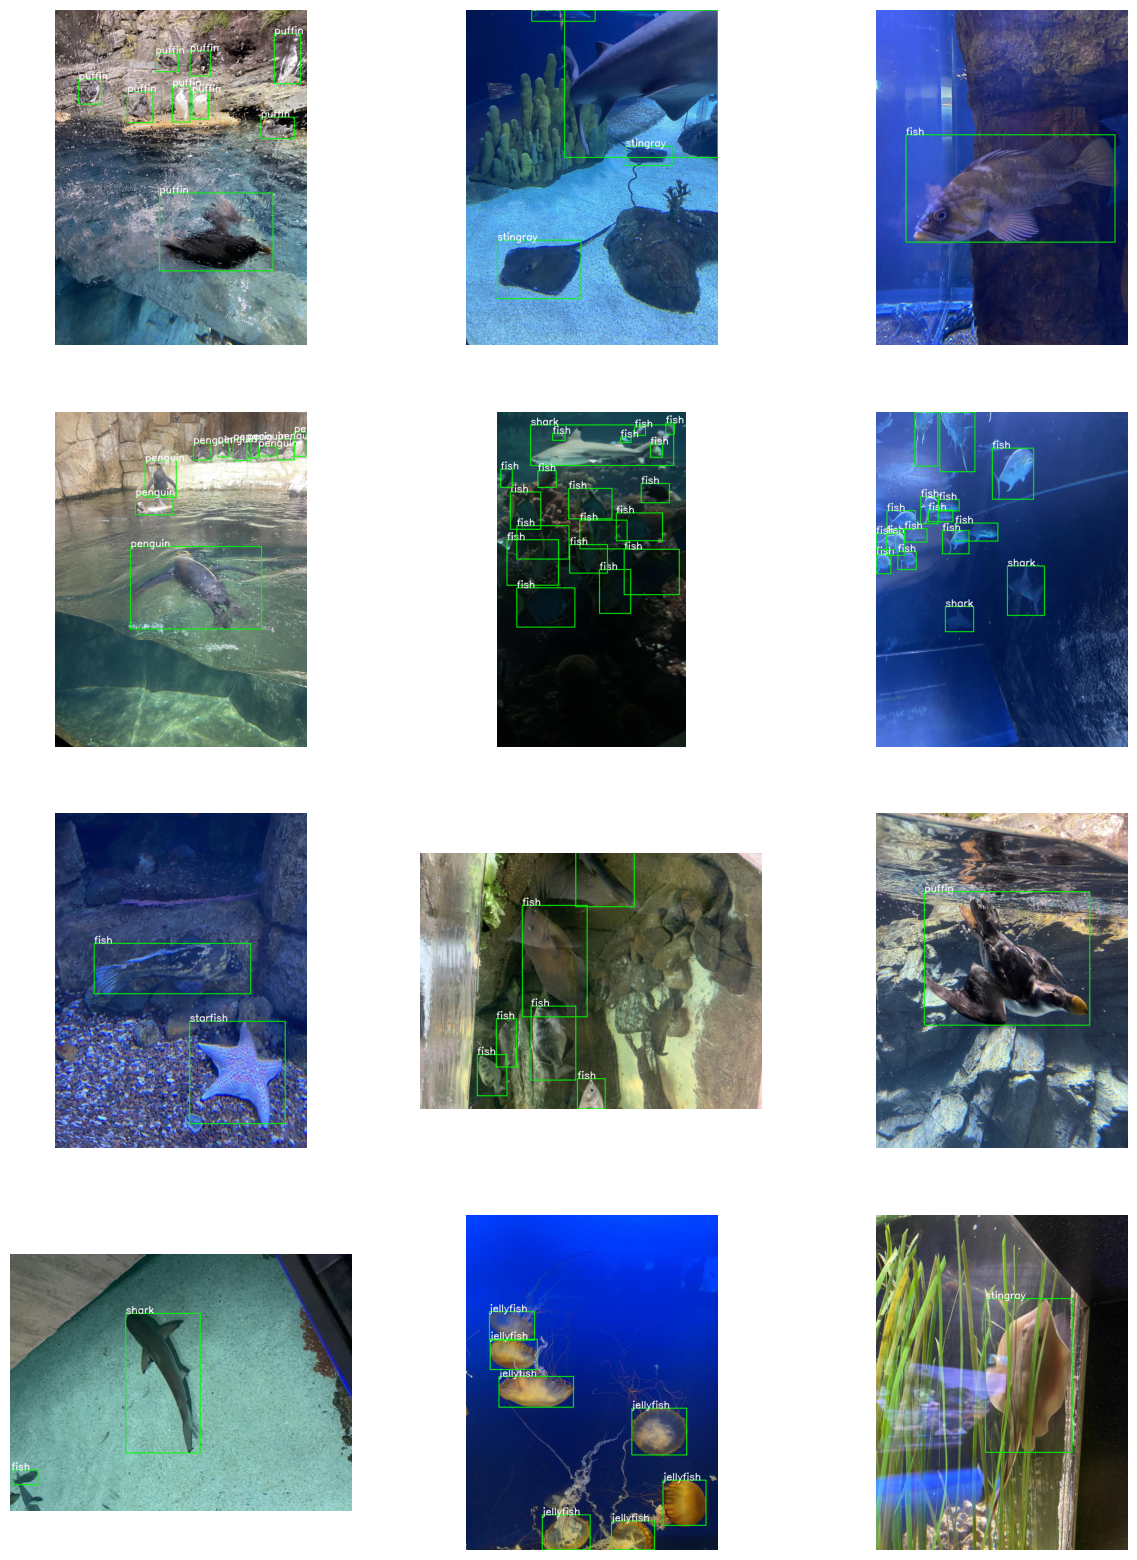

In [6]:
def visualize_image_with_annotation_bboxes(image_dir, label_dir):
    image_files = sorted(os.listdir(image_dir))
    
    sample_image_files = random.sample(image_files, 12)
    fig, axs = plt.subplots(4, 3, figsize=(15, 20))
    for i, image_file in enumerate(sample_image_files):
        row = i // 3
        col = i % 3
        
        # Load the image
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load the labels for this image
        label_path = os.path.join(label_dir, image_file[:-4] + '.txt')
        f = open(label_path, 'r')
        
        # Loop over the labels and plot the bounding boxes
        for label in f:
            class_id, x_center, y_center, width, height = map(float, label.split())
            h, w, _ = image.shape
            x_min = int((x_center - width/2) * w)
            y_min = int((y_center - height/2) * h)
            x_max = int((x_center + width/2) * w)
            y_max = int((y_center + height/2) * h)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image, Idx2Label[int(class_id)], (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
    
        axs[row, col].imshow(image)
        axs[row, col].axis('off')

    plt.show()

# Visualize 6 sample images with bounding boxes
visualize_image_with_annotation_bboxes(train_images, train_labels)

In [7]:
def count_images_and_labels(image_dir, label_dir):
    image_files = os.listdir(image_dir)
    label_files = os.listdir(label_dir)
    
    print(f"Number of images: {len(image_files)}")
    print(f"Number of labels: {len(label_files)}")


print("Training set:")
count_images_and_labels(train_images, train_labels)


print("\nValidation set:")
count_images_and_labels(val_images, val_labels)


print("\nTest set:")
count_images_and_labels(test_images, test_labels)


Training set:
Number of images: 448
Number of labels: 448

Validation set:
Number of images: 127
Number of labels: 127

Test set:
Number of images: 63
Number of labels: 63


In [8]:
# Read a image by path
image_path = os.path.join(train_images, os.listdir(train_images)[100])
image = cv2.imread(image_path)

# Get the size of the image
height, width, channels = image.shape
print('The image has dimensions {}x{} and {} channels'.format(height, width, channels))

The image has dimensions 1024x768 and 3 channels


In [9]:
%%writefile /kaggle/working/data.yaml
# Path
train: /kaggle/input/aquarium-data-cots/aquarium_pretrain/train/images
val: /kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/images
test: /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images

# Classes
nc: 7
names: ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

Writing /kaggle/working/data.yaml


## Model Training
Train mode is used for training a YOLOv8 model on a custom dataset. In this mode, the model is trained using the specified dataset and hyperparameters. The training process involves optimizing the model's parameters so that it can accurately predict the classes and locations of objects in an image.

In [10]:

model = YOLO('yolov8s.pt')
print(model)




100%|██████████| 21.5M/21.5M [00:00<00:00, 215MB/s]


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [11]:
# Training the model
results = model.train(
    data='/kaggle/working/data.yaml',
    epochs=150,
    imgsz=(height, width, channels),
    seed=42,
    batch=16, 
    workers=4,
    name='yolov8s_custom')

Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/data.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=(1024, 768, 3), save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=yolov8s_custom, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=T

100%|██████████| 755k/755k [00:00<00:00, 22.3MB/s]
2024-04-21 08:03:48,609	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-21 08:03:49,399	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-04-21 08:03:51.608456: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 08:03:51.608555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 08:03:51.727164: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS facto

Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

wandb: Currently logged in as: anhduong1710 (group4_cv). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240421_080401-elijfrp4
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run yolov8s_custom
wandb: ⭐️ View project at https://wandb.ai/group4_cv/YOLOv8
wandb: 🚀 View run at https://wandb.ai/group4_cv/YOLOv8/runs/elijfrp4


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 109MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=1024'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /kaggle/input/aquarium-data-cots/aquarium_pretrain/train/labels... 448 images, 1 backgrounds, 0 corrupt: 100%|██████████| 448/448 [00:02<00:00, 169.72it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/aquarium-data-cots/aquarium_pretrain/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/labels... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<00:00, 171.37it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/aquarium-data-cots/aquarium_pretrain/valid is not writeable, cache not saved.


Plotting labels to runs/detect/yolov8s_custom/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8s_custom
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      9.58G      1.495      3.567      1.438        137       1024: 100%|██████████| 28/28 [00:24<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        127        909      0.291       0.35      0.266      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      9.77G      1.498      2.179      1.356        248       1024: 100%|██████████| 28/28 [00:18<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

                   all        127        909      0.347      0.409      0.334      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      10.3G      1.471      1.908      1.349        240       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        127        909      0.418      0.406      0.401      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      9.56G      1.482      1.745      1.385        123       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        127        909      0.521        0.4      0.422       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      9.32G      1.434      1.587      1.339        158       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

                   all        127        909      0.536      0.425      0.422       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      9.55G      1.415      1.422      1.316        283       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        127        909      0.664      0.457      0.505      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      9.56G      1.368      1.366      1.293        213       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        127        909       0.65      0.446      0.514      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      9.71G      1.395        1.3      1.287        309       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        909      0.714      0.495      0.567      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      9.42G      1.391      1.256      1.292        165       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909      0.597      0.509      0.572      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      9.29G      1.318       1.19      1.274        140       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        127        909       0.71      0.533      0.609      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      9.29G       1.33      1.156      1.259        189       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        127        909      0.637      0.531      0.587      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      9.23G      1.313      1.122      1.259        224       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        127        909      0.701       0.59       0.63      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      9.43G      1.307      1.085      1.272        193       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.637      0.572      0.588      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      9.45G      1.287      1.066      1.244        203       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        127        909      0.702      0.597      0.651      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      9.77G      1.268      1.012      1.218        157       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.654        0.6      0.626      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      9.09G      1.253     0.9999      1.214        248       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.684      0.637      0.675      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      9.29G       1.23     0.9548      1.198        227       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        127        909      0.689      0.625      0.671      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      9.31G      1.228     0.9591      1.213        180       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.726       0.62      0.672      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      9.25G      1.204     0.9412      1.181        208       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        127        909       0.78      0.606      0.691      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      9.83G      1.208     0.9604      1.177        120       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

                   all        127        909      0.741       0.65      0.694      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      9.55G      1.189     0.9344      1.183        141       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.775      0.624      0.697      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      9.91G      1.195     0.9101      1.174        153       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909      0.688      0.659      0.681      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      9.29G      1.189      0.875       1.17        338       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        127        909      0.754       0.64      0.692      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      9.26G      1.174     0.8875      1.176        186       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        127        909       0.71      0.647      0.708      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      9.46G      1.185     0.8805      1.167        212       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909      0.762      0.672      0.724       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      9.34G      1.159     0.8287      1.145        183       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        127        909      0.712      0.654      0.674      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      9.77G      1.143     0.8235      1.137        252       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        127        909      0.778      0.648      0.701      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      9.37G      1.144     0.8296      1.134        185       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.727      0.657      0.708       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      9.74G      1.127     0.8194      1.137        164       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        127        909      0.775      0.634      0.696      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      9.55G      1.105     0.7924      1.127        204       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        127        909      0.753      0.615      0.671      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      9.26G      1.124     0.7843      1.145        207       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        127        909      0.786      0.671      0.738      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      9.55G      1.109     0.7847      1.127        252       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909      0.797      0.653      0.735      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      10.2G      1.056     0.7213      1.101        214       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        127        909      0.785      0.666      0.728      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      9.75G      1.078     0.7592       1.11        250       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        909      0.716      0.703      0.735      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      9.36G      1.051     0.7205      1.101        241       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        127        909      0.804      0.656      0.727      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150       9.7G       1.07     0.7343      1.107        241       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        909      0.743      0.686      0.722      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      9.34G      1.061      0.721      1.113        196       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        127        909      0.721      0.722      0.739      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      9.27G      1.019     0.6977      1.084        177       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.785      0.667      0.729      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      9.31G       1.06     0.7006      1.095        158       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        127        909      0.795      0.691      0.735      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      9.29G       1.06     0.6903      1.089        190       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        127        909      0.786      0.695      0.757      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      9.72G      1.022     0.6845      1.076        211       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        127        909      0.787      0.677      0.729      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      9.37G      1.034     0.6875      1.088        254       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        127        909      0.773      0.707      0.736       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      9.42G      1.064     0.7201      1.104        240       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        127        909      0.745      0.694       0.74      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      9.55G       1.04     0.6821      1.091        205       1024: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909      0.752      0.687      0.719      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      9.55G       1.04     0.6776       1.09        164       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.817      0.674       0.75      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      9.73G      1.036     0.6683      1.076        119       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        127        909        0.8      0.685      0.743      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      9.76G     0.9683     0.6294      1.052        196       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909      0.794      0.701      0.749      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      9.27G     0.9826     0.6275      1.062        170       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.818      0.714      0.759      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      9.72G     0.9548     0.6075      1.044        157       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        909      0.815      0.681       0.75      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      9.55G     0.9413     0.6158      1.047        145       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        127        909      0.791      0.691       0.75      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      9.55G     0.9655     0.6262      1.058        186       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.742      0.726      0.745      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      9.29G     0.9722     0.6161      1.046        293       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        127        909      0.795      0.693      0.745      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      9.32G     0.9457     0.5929      1.038        164       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        127        909      0.767      0.699      0.726      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      9.82G     0.9437     0.5883      1.028        211       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        127        909      0.803      0.682       0.75      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      9.31G     0.9446     0.5895      1.034        140       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        909      0.819      0.685      0.753      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      9.74G     0.9531     0.6012       1.05        223       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        127        909      0.797      0.679      0.732      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      9.28G     0.9248     0.6027      1.034        201       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.779      0.704      0.758      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      9.37G     0.8998     0.5816      1.021        164       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        127        909      0.766      0.702      0.741      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      9.55G     0.9248     0.5737      1.037        177       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        909      0.781      0.708      0.747      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150       9.6G     0.9021     0.5748      1.023        147       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        909      0.812      0.669      0.738       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      9.69G     0.8417     0.5327      1.001        245       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        127        909      0.767      0.696      0.747      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      9.29G       0.89     0.5579       1.02        109       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.762       0.71      0.748      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      9.55G     0.8934     0.5577      1.011        154       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.744      0.728      0.749      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      9.72G     0.8794     0.5487      1.008        158       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        127        909      0.836       0.68      0.759      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      9.27G     0.8667       0.54      1.003        249       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        127        909      0.844      0.678      0.766      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150       9.3G     0.8595     0.5389          1        220       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        127        909      0.827      0.699      0.764      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      9.55G     0.8599     0.5424     0.9974        260       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        127        909      0.809      0.689      0.765      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150       9.7G     0.8608     0.5325      1.014        198       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        127        909      0.807      0.715      0.774      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      9.24G     0.8509     0.5314      1.002        168       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        127        909      0.828      0.686      0.749      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      9.75G     0.8416       0.53     0.9978        209       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        127        909      0.806      0.709      0.766      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      9.71G     0.8881     0.5336      1.004        227       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        909      0.782      0.737      0.772      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      9.55G     0.8636     0.5322      1.007        285       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        127        909      0.824      0.709      0.772      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      9.28G     0.8272     0.5057     0.9798        271       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        127        909      0.809      0.716      0.763      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150       9.3G     0.8474     0.5176     0.9964        215       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909      0.835      0.687      0.754      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      9.73G     0.8225     0.5022     0.9918        185       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        909       0.81      0.734      0.775      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      9.74G     0.8177     0.4987     0.9931        195       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        127        909      0.822      0.725      0.776      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      9.55G     0.8105     0.5141     0.9912        178       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        127        909      0.793      0.754      0.777      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      9.85G     0.8046       0.51     0.9785        204       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        127        909      0.774      0.724      0.764      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      9.55G     0.8235     0.5047     0.9828        230       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        127        909       0.82      0.711      0.777      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      9.24G     0.7956     0.5049     0.9749        203       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.811      0.705      0.761      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      9.65G     0.7915     0.4908     0.9697        282       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        127        909      0.794      0.731      0.751      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      9.28G     0.7907      0.482     0.9778        202       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        127        909      0.768      0.719      0.749      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      9.55G     0.7769     0.4729     0.9695        199       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        127        909      0.772      0.754      0.765      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      9.34G     0.7654     0.4746     0.9579        173       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909      0.797      0.716      0.774      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      9.55G     0.7846     0.4756     0.9717        163       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        127        909      0.804      0.742      0.779      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      9.28G     0.7771     0.4789     0.9714        172       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.838      0.699      0.769      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      9.31G       0.78     0.4754     0.9672        296       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        127        909      0.827      0.706      0.764      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      9.55G     0.7744     0.4753     0.9658        242       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        127        909      0.801      0.727      0.772      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      9.21G     0.7382     0.4607     0.9573        211       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.793      0.761      0.788      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150       9.3G     0.7491     0.4525     0.9613        194       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        127        909      0.769      0.746      0.783      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      9.31G     0.7378     0.4453     0.9566        176       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        127        909      0.797      0.743      0.783       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      9.29G     0.7406     0.4429     0.9552        169       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        127        909      0.837      0.702      0.777      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      9.27G     0.7413      0.453     0.9497        220       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        909      0.805      0.716      0.772      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      9.55G     0.7234     0.4451     0.9519        201       1024: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909      0.838      0.699      0.782      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      9.31G      0.729     0.4485     0.9438        256       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        909       0.83      0.708      0.782      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      9.55G     0.7181     0.4344     0.9471        135       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.808      0.711       0.77      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      9.25G     0.7238     0.4485     0.9503        247       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        127        909      0.848      0.709      0.781      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      9.72G      0.704     0.4349     0.9401        162       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        127        909      0.814      0.735      0.784       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      9.24G     0.7005      0.432     0.9307        114       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909      0.858      0.734      0.788      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      9.68G     0.7008     0.4297     0.9385        130       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        127        909      0.844      0.713      0.774      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      9.29G      0.746     0.4479     0.9505        194       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909      0.806       0.74      0.786      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      9.33G     0.6959      0.423     0.9329        190       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        127        909      0.854      0.701      0.784      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      9.92G     0.6653     0.4227     0.9286        127       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.838       0.72      0.789      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      9.32G     0.6835     0.4223     0.9303        248       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909      0.855      0.697      0.777      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      9.55G     0.6794     0.4275     0.9228        280       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all        127        909      0.787      0.732      0.775      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      9.55G     0.6828     0.4165     0.9229        164       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        127        909      0.777      0.729      0.768      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      9.23G     0.6791     0.4176     0.9258        155       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.798      0.729      0.766      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      9.68G     0.6911     0.4231      0.933        202       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        127        909      0.767      0.758      0.769      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      9.33G     0.6784     0.4171     0.9304        265       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        909      0.854      0.712      0.774       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      9.22G     0.6619     0.4185     0.9289        238       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909      0.816      0.743       0.78      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      9.31G     0.6657     0.4049     0.9299        149       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909      0.804      0.745      0.778      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      9.21G     0.6422     0.4027     0.9121        203       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        909      0.832      0.722      0.778      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      9.78G     0.6522      0.401     0.9222        269       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        127        909      0.818      0.721      0.781      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      9.89G     0.6468     0.3973     0.9196        132       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        127        909      0.824      0.717      0.772      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      9.21G     0.6658     0.4094     0.9225        172       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        127        909      0.787      0.719      0.775      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      9.24G     0.6423     0.3941     0.9207        183       1024: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        127        909       0.85      0.696      0.784      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      9.82G     0.6514      0.398     0.9146        277       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        909      0.814      0.715      0.786      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      9.55G     0.6287     0.3898     0.9125        181       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        127        909      0.823      0.728      0.787      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      9.55G     0.6264     0.3887     0.9074        173       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        127        909      0.865      0.679      0.783      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      9.55G     0.6202     0.3794     0.9147        304       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        127        909       0.83      0.721      0.796      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      9.25G     0.6403     0.3943     0.9153        289       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        127        909      0.812      0.754      0.794      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      9.29G     0.6208     0.3839     0.9117        154       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909      0.835      0.734      0.795      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      9.55G     0.5899     0.3643     0.9016        205       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909      0.844      0.724      0.787      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      9.29G     0.6092     0.3787     0.9087        136       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        127        909       0.84      0.722       0.79      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      9.62G     0.6122     0.3775     0.8952        235       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        127        909      0.868      0.698      0.798      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      9.33G     0.5996     0.3701     0.8996        188       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        909      0.849      0.711        0.8      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      9.33G     0.6005      0.378     0.9047        175       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        127        909      0.843      0.727      0.799      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      9.26G     0.5936     0.3694     0.9016        228       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        127        909      0.834      0.723      0.789      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      9.85G     0.5788     0.3683     0.8981        244       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909       0.82      0.733      0.791      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150       9.3G     0.5865     0.3699     0.9007        280       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        909      0.836      0.716      0.795      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      9.55G     0.5719      0.361     0.8976        152       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        127        909      0.847      0.719      0.789      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      9.55G     0.5751      0.359     0.8908        139       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        909      0.852       0.71      0.792      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      9.55G     0.5821     0.3663     0.8968        152       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        127        909       0.86      0.706      0.793      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      9.55G     0.5833     0.3638      0.886        231       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909      0.862      0.692      0.793      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      10.2G     0.5825      0.368     0.8945        176       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        127        909      0.805      0.743      0.796      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      10.4G     0.5942     0.3686     0.9062        206       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        127        909      0.821      0.728      0.796      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      9.28G     0.5723     0.3576     0.8949        200       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909      0.862      0.696      0.796      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      9.68G     0.5724     0.3544     0.8878        174       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all        127        909      0.872      0.701      0.797      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      9.46G     0.5736     0.3564     0.8912        126       1024: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        127        909      0.862      0.701      0.795      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      9.26G     0.5764     0.3569     0.8969        186       1024: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        127        909      0.858      0.696      0.793      0.499


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      9.86G     0.5734     0.3428     0.8791        172       1024: 100%|██████████| 28/28 [00:21<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        127        909      0.768      0.729      0.773      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      9.23G     0.5451     0.3226     0.8629         91       1024: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        127        909      0.859      0.673      0.773      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      9.55G     0.5555     0.3223     0.8742        118       1024: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        127        909      0.787      0.737      0.778      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      9.55G     0.5284     0.3092     0.8629        100       1024: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        127        909      0.773      0.745       0.78      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      9.55G     0.5104      0.298     0.8576        140       1024: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        127        909      0.781      0.746      0.784      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      9.55G     0.4911     0.2901     0.8474        153       1024: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all        127        909      0.802      0.743      0.787      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      9.25G     0.4957     0.2912     0.8534        194       1024: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        127        909      0.792      0.741      0.788      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      9.55G     0.5007     0.2876     0.8489         82       1024: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        127        909      0.802      0.735       0.79      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      9.55G     0.5075     0.2983     0.8567        141       1024: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        127        909       0.82      0.721      0.788        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      9.55G     0.4839     0.2879     0.8465        121       1024: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        127        909      0.815       0.72      0.786        0.5



150 epochs completed in 0.898 hours.
Optimizer stripped from runs/detect/yolov8s_custom/weights/last.pt, 22.6MB
Optimizer stripped from runs/detect/yolov8s_custom/weights/best.pt, 22.6MB

Validating runs/detect/yolov8s_custom/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 11128293 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


                   all        127        909      0.854      0.709        0.8      0.507
                  fish        127        459      0.878      0.737       0.84      0.491
             jellyfish        127        155      0.894      0.877      0.935      0.594
               penguin        127        104      0.685      0.788      0.744      0.354
                puffin        127         74      0.787      0.449       0.62      0.332
                 shark        127         57      0.925      0.719      0.813      0.551
              starfish        127         27      0.981      0.667      0.802      0.591
              stingray        127         33      0.828      0.727      0.842      0.634
Speed: 0.5ms preprocess, 11.2ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/yolov8s_custom


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▅███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▅███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▅███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▁▂▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████████████
wandb:     metrics/mAP50-95(B) ▁▂▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇█▇██████▇██
wandb:    metrics/precision(B) ▁▃▆▆▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇██▇▇▇▇██████▇█
wandb:       metrics/recall(B) ▁▁▃▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇▇▇▆█▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁
wandb:          train/cls_loss █▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss ██▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁
wandb:            val/box_loss ██▆▄▃▃▂▃▂▂▂▂▂▂▂▃▁▂▃▃▂▃▂▂▂▂▂▁▂▁▂▂▂▁▁

## Performance
* Train Box Loss:đo lường sự khác biệt giữa các hộp giới hạn được dự đoán và các hộp giới hạn thực tế của các đối tượng trong dữ liệu huấn luyện.
* Train Class Loss: đo lường sự khác biệt giữa xác suất của lớp được dự đoán và nhãn lớp thực tế của các đối tượng trong dữ liệu huấn luyện.
* Train DFL (Dynamic Feature Learning) Loss: đo lường sự khác biệt giữa bản đồ đặc điểm dự đoán và bản đồ đặc điểm thực tế của các đối tượng trong dữ liệu huấn luyện.
* Metrics Precision (B): đo tỷ lệ phát hiện dương tính thực sự trong số tất cả các hộp giới hạn được dự đoán.
* Metrics Recall (B): số liệu đo lường tỷ lệ phát hiện dương tính thực sự trong số tất cả các hộp giới hạn thực tế.
* Metrics mAP50 (B): đo lường độ chính xác trung bình trung bình của mô hình trên các loại đối tượng khác nhau, với mức giao nhau 50% (IoU) threshold.
* Metrics mAP50-95 (B): đo độ chính xác trung bình trung bình của mô hình trên các loại đối tượng khác nhau, với ngưỡng IoU dao động từ 50% đến 95%.

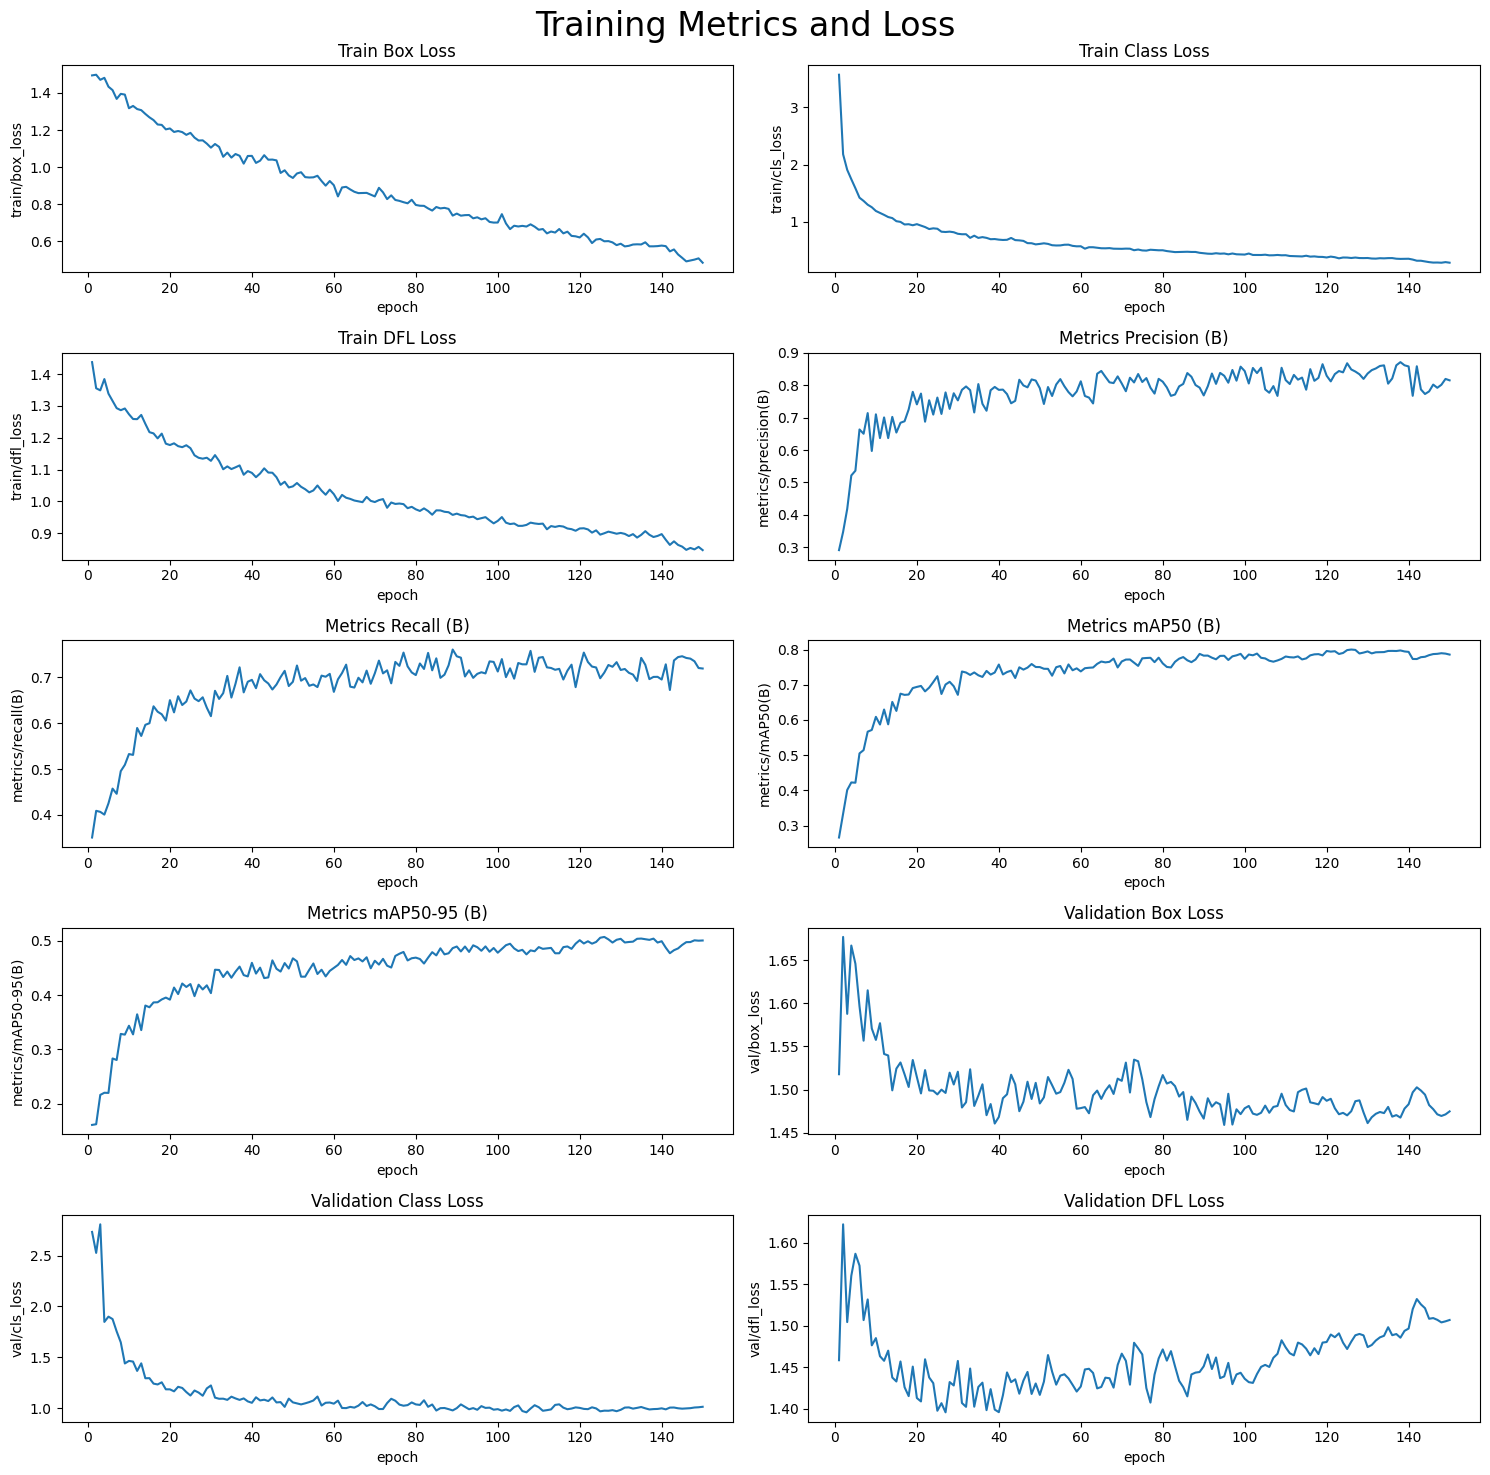

In [12]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/yolov8s_custom/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

## Evaluation

In [13]:
# # Loading the best performing model
# model = YOLO('/kaggle/working/runs/detect/yolov8s_custom/weights/best.pt')

# # Evaluating the model on test dataset
# metrics = model.val(conf=0.25, split='test')

In [14]:
model = YOLO('/kaggle/working/runs/detect/yolov8s_custom/weights/best.pt')

# Evaluating the model on the validation dataset
metrics = model.val(
    data='/kaggle/working/data.yaml',  # YAML file that specifies dataset paths
    imgsz=640,  # Specify an image size (or use the same as during training)
    conf=0.25,  # Confidence threshold
    iou=0.5,    # IoU threshold for NMS
    split='val'  # Specify to use the validation split
)

# Display validation metrics
print("Validation metrics:", metrics)

Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 11128293 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /kaggle/input/aquarium-data-cots/aquarium_pretrain/valid/labels... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<00:00, 705.94it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/aquarium-data-cots/aquarium_pretrain/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


                   all        127        909       0.84      0.713      0.796      0.533
                  fish        127        459      0.862       0.75      0.837      0.535
             jellyfish        127        155      0.912      0.867      0.928      0.585
               penguin        127        104      0.699       0.76      0.704      0.368
                puffin        127         74      0.721      0.454      0.621      0.386
                 shark        127         57      0.833      0.699      0.782      0.524
              starfish        127         27          1      0.704      0.852      0.666
              stingray        127         33      0.852      0.758      0.849      0.667
Speed: 0.1ms preprocess, 11.8ms inference, 0.0ms loss, 15.7ms postprocess per image
Results saved to runs/detect/val
Validation metrics: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object

In [15]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(f"Mean Average Precision @ .50   : {metrics.box.map50}") 
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.533001721022555
Mean Average Precision @ .50   : 0.7962924514057159
Mean Average Precision @ .70   : 0.5629489068229117


In [16]:
# # Average IoU
# # average_iou_yolov8s = metrics.box.mean_results()[0] 

# # mAP (Mean Average Precision)
mAP_yolov8s = metrics.box.map50  

# # In ra các chỉ số

# print("Average IoU:", average_iou_yolov8s)
print("mAP:", mAP_yolov8s)


mAP: 0.7962924514057159


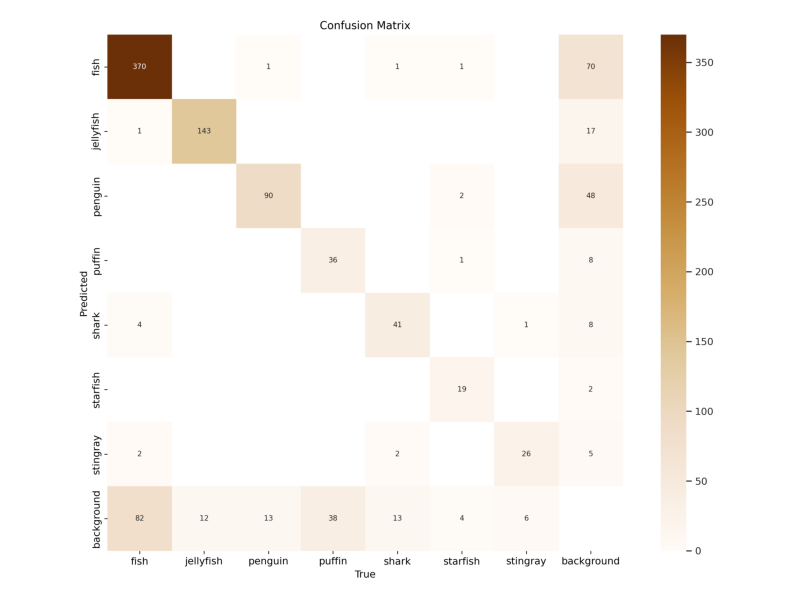

In [17]:
import matplotlib.pyplot as plt
import cv2

# Đọc hình ảnh của confusion matrix
confusion_matrix_img_path = '/kaggle/working/runs/detect/yolov8s_custom/confusion_matrix.png'
confusion_matrix_img = cv2.imread(confusion_matrix_img_path)

# Hiển thị hình ảnh
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix_img)
plt.axis('off')
plt.show()


## Making Predictions on Test Images

In [18]:

def predict_detection(image_path):
    image = cv2.imread(image_path)
    detect_result = model(image)
    detect_image = detect_result[0].plot()
    detect_image = cv2.cvtColor(detect_image, cv2.COLOR_BGR2RGB)
    return detect_image


0: 1024x768 24 penguins, 73.0ms
Speed: 6.7ms preprocess, 73.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 768)

0: 1024x768 2 fishs, 11.1ms
Speed: 7.6ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 768)

0: 1024x768 19 penguins, 11.1ms
Speed: 4.8ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 768)

0: 768x1024 10 fishs, 1 shark, 1 stingray, 69.8ms
Speed: 5.0ms preprocess, 69.8ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)

0: 1024x768 10 jellyfishs, 11.9ms
Speed: 5.0ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 768)

0: 1024x768 19 jellyfishs, 11.1ms
Speed: 4.8ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 768)

0: 1024x768 17 fishs, 2 sharks, 11.1ms
Speed: 5.1ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 768)

0: 1024x768 1 fish, 1 starfish, 11.1ms
Speed: 4.9ms prepr

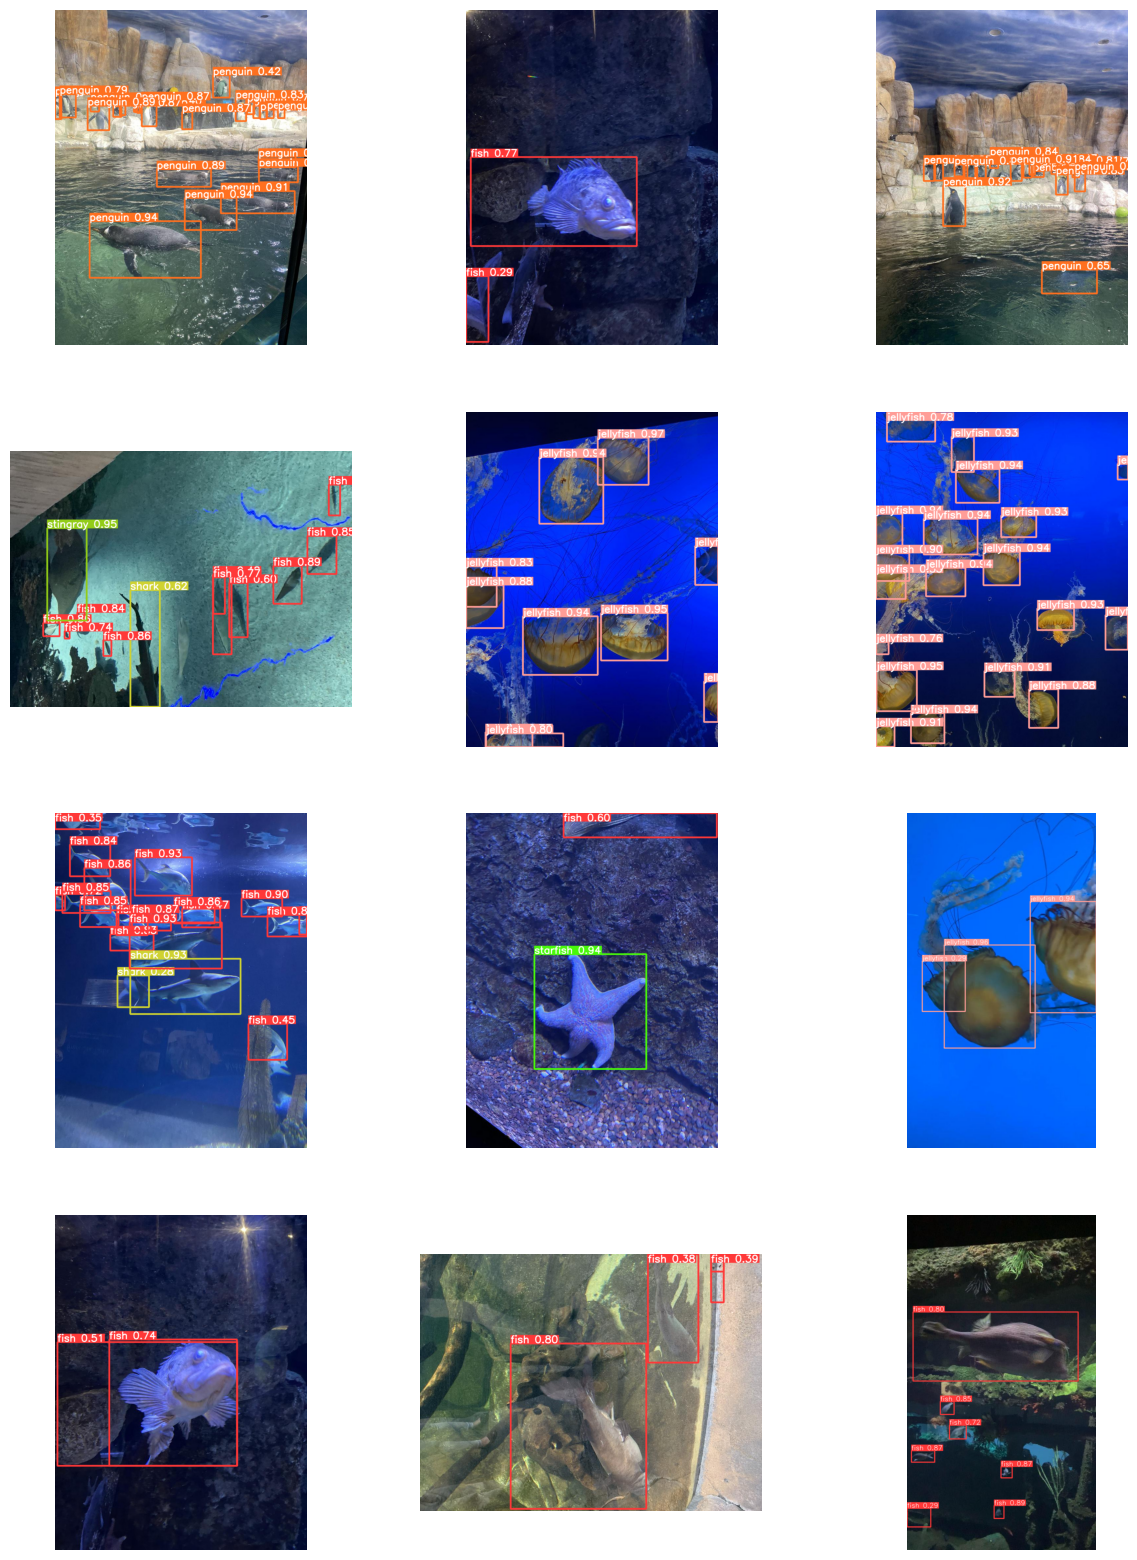

In [19]:

image_files = sorted(os.listdir(test_images))
    
# Choose 12 random image files from the list
sample_image_files = random.sample(image_files, 12)
fig, axs = plt.subplots(4, 3, figsize=(15, 20))
    

for i, image_file in enumerate(sample_image_files):
    row = i // 3
    col = i % 3
        
    
    image_path = os.path.join(test_images, image_file)
    detect_image = predict_detection(image_path)
    
    axs[row, col].imshow(detect_image)
    axs[row, col].axis('off')

plt.show()

# Faster R-CNN

In [20]:
!pip install pycocotools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 8.3 MB/s eta 0:00:00


In [21]:
import numpy as np 
import pandas as pd 
import os
import wandb
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO

### Xử lý dữ liệu

In [22]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [23]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [24]:
dataset_path = "/kaggle/input/aquarium-dataset/Aquarium Combined"


In [25]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

In [26]:
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [27]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [28]:
train_dataset

Dataset AquariumDetection
    Number of datapoints: 447
    Root location: /kaggle/input/aquarium-dataset/Aquarium Combined
    Compose([
  Resize(always_apply=False, p=1, height=600, width=600, interpolation=1),
  HorizontalFlip(always_apply=False, p=0.3),
  VerticalFlip(always_apply=False, p=0.3),
  RandomBrightnessContrast(always_apply=False, p=0.1, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  ColorJitter(always_apply=False, p=0.1, brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=[-0.2, 0.2]),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'coco', 'label_fields': None, 'min_area': 0.0, 'min_visibility': 0.0, 'min_width': 0.0, 'min_height': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={}, is_check_shapes=True)

In [29]:
len(train_dataset)

447

### Model

In [30]:
model_f = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model_f.roi_heads.box_predictor.cls_score.in_features
model_f.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 157MB/s]


In [31]:
def collate_fn(batch):
    return tuple(zip(*batch))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [32]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model_f(images, targets) # just make sure this runs without error

In [33]:
device = torch.device("cuda") # use GPU to train
model_f = model_f.to(device)
print(model_f)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [34]:
params = [p for p in model_f.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.9, nesterov=True, weight_decay=1e-4)



In [35]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    # Calculate mean loss values for the current epoch
    mean_losses_dict = {}
    for key in losses_dict.keys():
        values = [d.get(key, 0) for d in all_losses_dict]  # Use 0 as default value if key is not present
        mean_losses_dict[key] = np.mean(values)
    
    # Append mean loss values to the losses dictionary
    for key in losses_dict.keys():
        losses_dict[key].append(mean_losses_dict[key])

    # Print epoch loss information
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        mean_losses_dict.get('loss_classifier', 0),
        mean_losses_dict.get('loss_box_reg', 0),
        mean_losses_dict.get('loss_rpn_box_reg', 0),
        mean_losses_dict.get('loss_objectness', 0)
    ))
    return np.mean(all_losses)

### Training

100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 0, lr: 0.010000, loss: 0.911221, loss_classifier: 0.417524, loss_box: 0.343480, loss_rpn_box: 0.044098, loss_object: 0.106118


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 1, lr: 0.010000, loss: 0.708189, loss_classifier: 0.328726, loss_box: 0.285316, loss_rpn_box: 0.035601, loss_object: 0.058545


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 2, lr: 0.010000, loss: 0.613979, loss_classifier: 0.270406, loss_box: 0.266731, loss_rpn_box: 0.032556, loss_object: 0.044285


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 3, lr: 0.010000, loss: 0.568870, loss_classifier: 0.237443, loss_box: 0.264965, loss_rpn_box: 0.030838, loss_object: 0.035624


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 4, lr: 0.010000, loss: 0.532908, loss_classifier: 0.209470, loss_box: 0.254832, loss_rpn_box: 0.029436, loss_object: 0.039169


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 5, lr: 0.010000, loss: 0.502047, loss_classifier: 0.194923, loss_box: 0.248130, loss_rpn_box: 0.028548, loss_object: 0.030446


100%|██████████| 112/112 [03:20<00:00,  1.79s/it]


Epoch 6, lr: 0.010000, loss: 0.453182, loss_classifier: 0.168936, loss_box: 0.237097, loss_rpn_box: 0.026279, loss_object: 0.020871


100%|██████████| 112/112 [03:20<00:00,  1.79s/it]


Epoch 7, lr: 0.010000, loss: 0.437809, loss_classifier: 0.158468, loss_box: 0.228862, loss_rpn_box: 0.026635, loss_object: 0.023844


100%|██████████| 112/112 [03:20<00:00,  1.79s/it]


Epoch 8, lr: 0.010000, loss: 0.411555, loss_classifier: 0.141805, loss_box: 0.226401, loss_rpn_box: 0.025005, loss_object: 0.018344


100%|██████████| 112/112 [03:22<00:00,  1.81s/it]


Epoch 9, lr: 0.010000, loss: 0.385237, loss_classifier: 0.133086, loss_box: 0.213565, loss_rpn_box: 0.022898, loss_object: 0.015687


100%|██████████| 112/112 [03:22<00:00,  1.80s/it]


Epoch 10, lr: 0.010000, loss: 0.383365, loss_classifier: 0.131772, loss_box: 0.210791, loss_rpn_box: 0.023285, loss_object: 0.017516


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 11, lr: 0.010000, loss: 0.372055, loss_classifier: 0.126919, loss_box: 0.204555, loss_rpn_box: 0.024753, loss_object: 0.015828


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 12, lr: 0.010000, loss: 0.357534, loss_classifier: 0.117768, loss_box: 0.204094, loss_rpn_box: 0.021787, loss_object: 0.013885


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 13, lr: 0.010000, loss: 0.328463, loss_classifier: 0.102399, loss_box: 0.192313, loss_rpn_box: 0.021379, loss_object: 0.012372


100%|██████████| 112/112 [03:19<00:00,  1.78s/it]


Epoch 14, lr: 0.010000, loss: 0.321527, loss_classifier: 0.101563, loss_box: 0.187907, loss_rpn_box: 0.020843, loss_object: 0.011214


100%|██████████| 112/112 [03:20<00:00,  1.79s/it]


Epoch 15, lr: 0.010000, loss: 0.302954, loss_classifier: 0.095674, loss_box: 0.177990, loss_rpn_box: 0.021097, loss_object: 0.008194


100%|██████████| 112/112 [03:20<00:00,  1.79s/it]


Epoch 16, lr: 0.010000, loss: 0.335367, loss_classifier: 0.105793, loss_box: 0.186968, loss_rpn_box: 0.022475, loss_object: 0.020131


100%|██████████| 112/112 [03:20<00:00,  1.79s/it]


Epoch 17, lr: 0.010000, loss: 0.309567, loss_classifier: 0.099851, loss_box: 0.178346, loss_rpn_box: 0.019656, loss_object: 0.011714


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 18, lr: 0.010000, loss: 0.290093, loss_classifier: 0.091855, loss_box: 0.168387, loss_rpn_box: 0.020849, loss_object: 0.009003


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 19, lr: 0.010000, loss: 0.283570, loss_classifier: 0.086824, loss_box: 0.167570, loss_rpn_box: 0.017988, loss_object: 0.011188


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 20, lr: 0.010000, loss: 0.274249, loss_classifier: 0.079708, loss_box: 0.168013, loss_rpn_box: 0.018921, loss_object: 0.007607


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 21, lr: 0.010000, loss: 0.264226, loss_classifier: 0.079571, loss_box: 0.159375, loss_rpn_box: 0.018055, loss_object: 0.007224


100%|██████████| 112/112 [03:22<00:00,  1.80s/it]


Epoch 22, lr: 0.010000, loss: 0.261150, loss_classifier: 0.078960, loss_box: 0.153058, loss_rpn_box: 0.017051, loss_object: 0.012082


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 23, lr: 0.010000, loss: 0.245736, loss_classifier: 0.071905, loss_box: 0.150073, loss_rpn_box: 0.016679, loss_object: 0.007079


100%|██████████| 112/112 [03:22<00:00,  1.80s/it]


Epoch 24, lr: 0.010000, loss: 0.247719, loss_classifier: 0.072372, loss_box: 0.151367, loss_rpn_box: 0.016861, loss_object: 0.007119


100%|██████████| 112/112 [03:20<00:00,  1.79s/it]


Epoch 25, lr: 0.010000, loss: 0.239429, loss_classifier: 0.070747, loss_box: 0.145505, loss_rpn_box: 0.016773, loss_object: 0.006405


100%|██████████| 112/112 [03:20<00:00,  1.79s/it]


Epoch 26, lr: 0.010000, loss: 0.234967, loss_classifier: 0.067546, loss_box: 0.146506, loss_rpn_box: 0.015974, loss_object: 0.004941


100%|██████████| 112/112 [03:20<00:00,  1.79s/it]


Epoch 27, lr: 0.010000, loss: 0.230695, loss_classifier: 0.069861, loss_box: 0.139672, loss_rpn_box: 0.015600, loss_object: 0.005563


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 28, lr: 0.010000, loss: 0.227929, loss_classifier: 0.066052, loss_box: 0.141281, loss_rpn_box: 0.015613, loss_object: 0.004983


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 29, lr: 0.010000, loss: 0.206262, loss_classifier: 0.058277, loss_box: 0.128894, loss_rpn_box: 0.014725, loss_object: 0.004366


100%|██████████| 112/112 [03:20<00:00,  1.79s/it]


Epoch 30, lr: 0.010000, loss: 0.217848, loss_classifier: 0.062733, loss_box: 0.134637, loss_rpn_box: 0.015017, loss_object: 0.005461


100%|██████████| 112/112 [03:20<00:00,  1.79s/it]


Epoch 31, lr: 0.010000, loss: 0.218155, loss_classifier: 0.063942, loss_box: 0.134500, loss_rpn_box: 0.014610, loss_object: 0.005103


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 32, lr: 0.010000, loss: 0.209609, loss_classifier: 0.059269, loss_box: 0.131400, loss_rpn_box: 0.014693, loss_object: 0.004248


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 33, lr: 0.010000, loss: 0.197852, loss_classifier: 0.056701, loss_box: 0.123922, loss_rpn_box: 0.013595, loss_object: 0.003633


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 34, lr: 0.010000, loss: 0.188572, loss_classifier: 0.051952, loss_box: 0.120872, loss_rpn_box: 0.012941, loss_object: 0.002806


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 35, lr: 0.010000, loss: 0.198259, loss_classifier: 0.056950, loss_box: 0.124228, loss_rpn_box: 0.013101, loss_object: 0.003980


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 36, lr: 0.010000, loss: 0.187127, loss_classifier: 0.053392, loss_box: 0.117299, loss_rpn_box: 0.012106, loss_object: 0.004330


100%|██████████| 112/112 [03:21<00:00,  1.79s/it]


Epoch 37, lr: 0.010000, loss: 0.187463, loss_classifier: 0.053328, loss_box: 0.117302, loss_rpn_box: 0.013163, loss_object: 0.003671


100%|██████████| 112/112 [03:22<00:00,  1.80s/it]


Epoch 38, lr: 0.010000, loss: 0.186340, loss_classifier: 0.051982, loss_box: 0.116689, loss_rpn_box: 0.013131, loss_object: 0.004538


100%|██████████| 112/112 [03:21<00:00,  1.80s/it]


Epoch 39, lr: 0.010000, loss: 0.192957, loss_classifier: 0.057144, loss_box: 0.118180, loss_rpn_box: 0.012889, loss_object: 0.004744


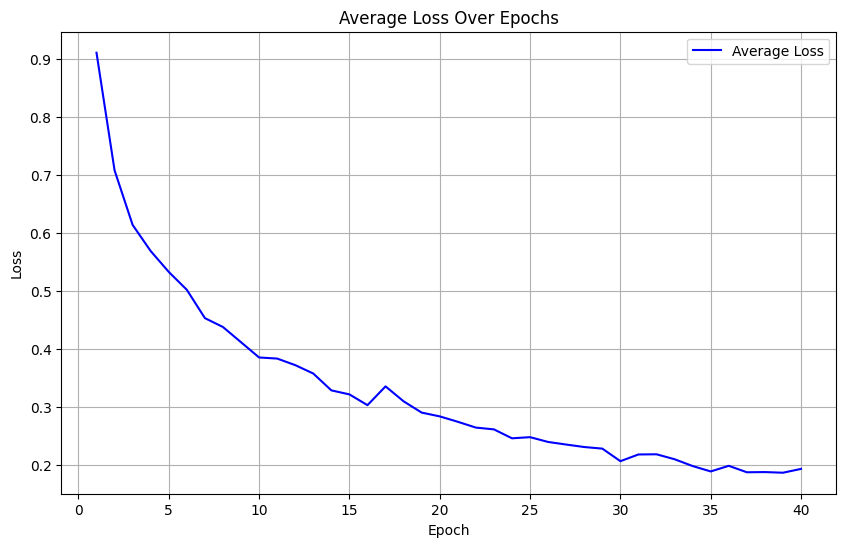

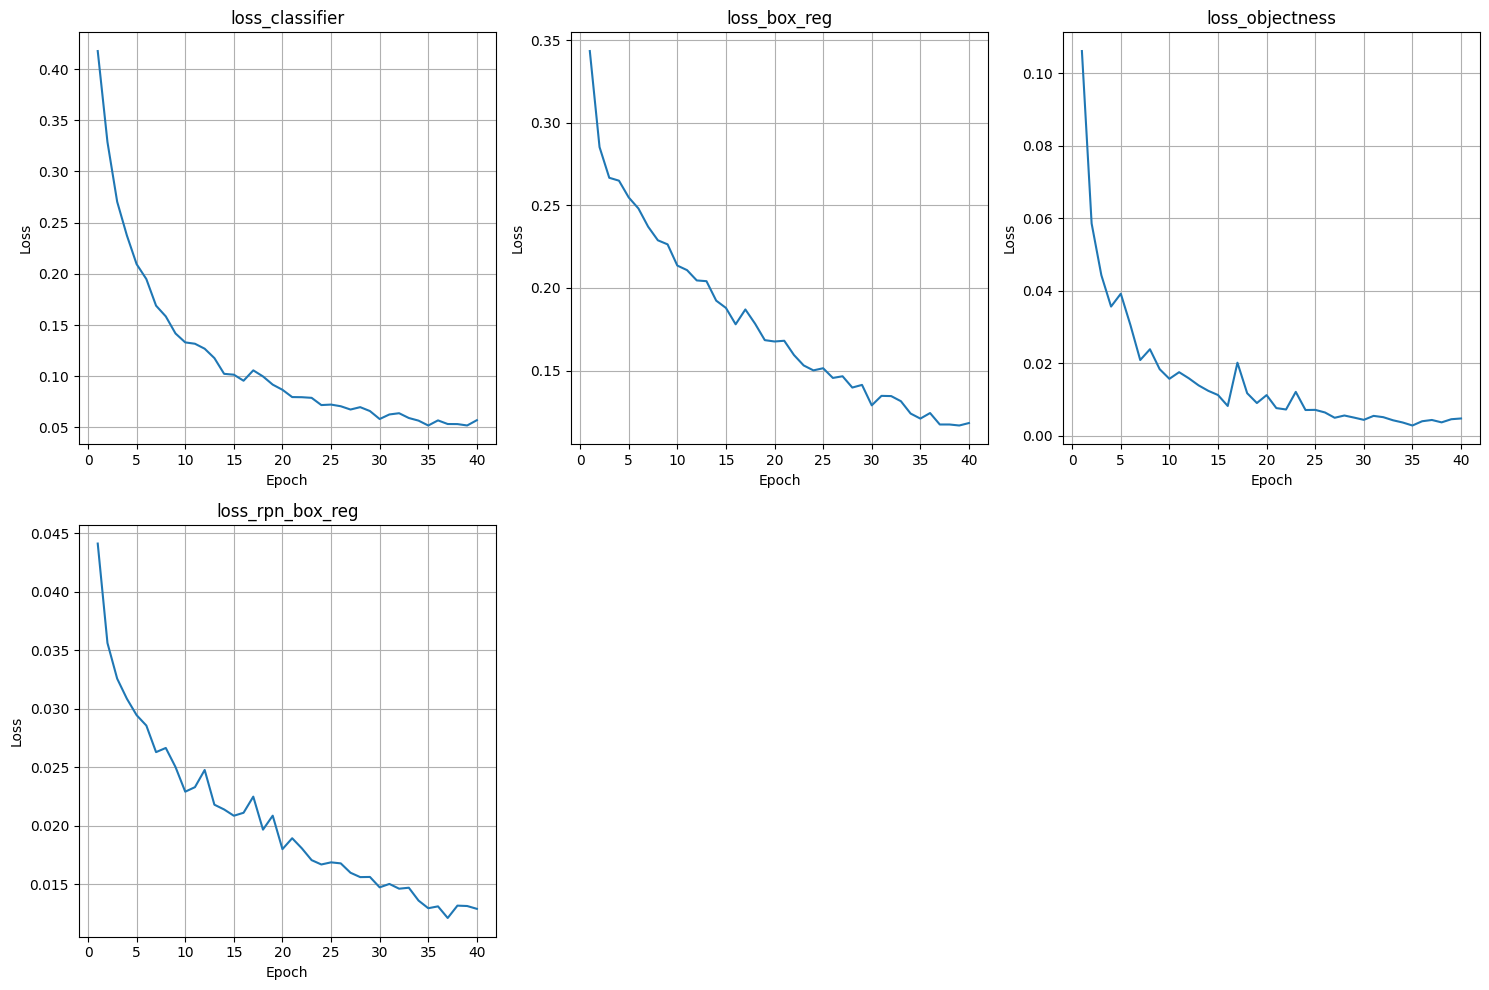

In [36]:
num_epochs = 40


losses_dict = {
    'loss_classifier': [],
    'loss_box_reg': [],
    'loss_objectness': [],
    'loss_rpn_box_reg': []
}


average_epoch_losses = []


for epoch in range(num_epochs):
    epoch_loss = train_one_epoch(model_f, optimizer, train_loader, device, epoch)
    average_epoch_losses.append(epoch_loss)




plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), average_epoch_losses, color='blue', label='Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()



keys = list(losses_dict.keys())
plt.figure(figsize=(15, 10))

for i in range(4):
    plt.subplot(2, 3, i+1)
    plt.plot(range(1, num_epochs + 1), losses_dict[keys[i]])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(keys[i])
    plt.grid(True)

plt.tight_layout()
plt.show()

### Evalution

In [37]:
dataset_path = "/kaggle/input/aquarium-dataset/Aquarium Combined"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


valid_dataset  = AquariumDetection(root=dataset_path, split='valid', transforms=get_transforms(False))


valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [38]:
def calculate_iou(box1, box2):
    # box1 and box2 should be in format [x1, y1, x2, y2]
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    iou = intersection_area / float(box1_area + box2_area - intersection_area)

    return iou


In [39]:
import numpy as np
import torch

def integrated_model_evaluation(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    
    all_detections = []  
    all_ground_truths = 0
    APs = []  # Danh sách chứa các Average Precision của từng lớp
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)
            
            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes'].cpu().numpy()
                scores = output['scores'].cpu().numpy()
                true_boxes = target['boxes'].cpu().numpy()
                
                for score, pred_box in zip(scores, pred_boxes):
                    best_iou = max([calculate_iou(pred_box, tb) for tb in true_boxes], default=0)
                    if best_iou >= iou_threshold:
                        all_detections.append([score, 1])
                    else:
                        all_detections.append([score, 0])
                
                all_ground_truths += len(true_boxes)
    
    all_detections.sort(key=lambda x: -x[0])
    cum_TP = np.cumsum([det[1] for det in all_detections])
    cum_FP = np.cumsum([1-det[1] for det in all_detections])
    precision = cum_TP / (cum_TP + cum_FP)
    recall = cum_TP / all_ground_truths
    
    AP = np.trapz(precision, recall)
    APs.append(AP)  # Thêm AP của lớp hiện tại vào danh sách APs
    
    mAP = np.mean(APs)  # Tính trung bình của tất cả các AP
    
    return mAP


In [40]:
mAP = integrated_model_evaluation(model_f, valid_loader, device, iou_threshold=0.5)
print("mAP on validation set:", mAP)

mAP on validation set: 0.8930987012596396


### Predict

In [41]:
model_f.eval()
torch.cuda.empty_cache()
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


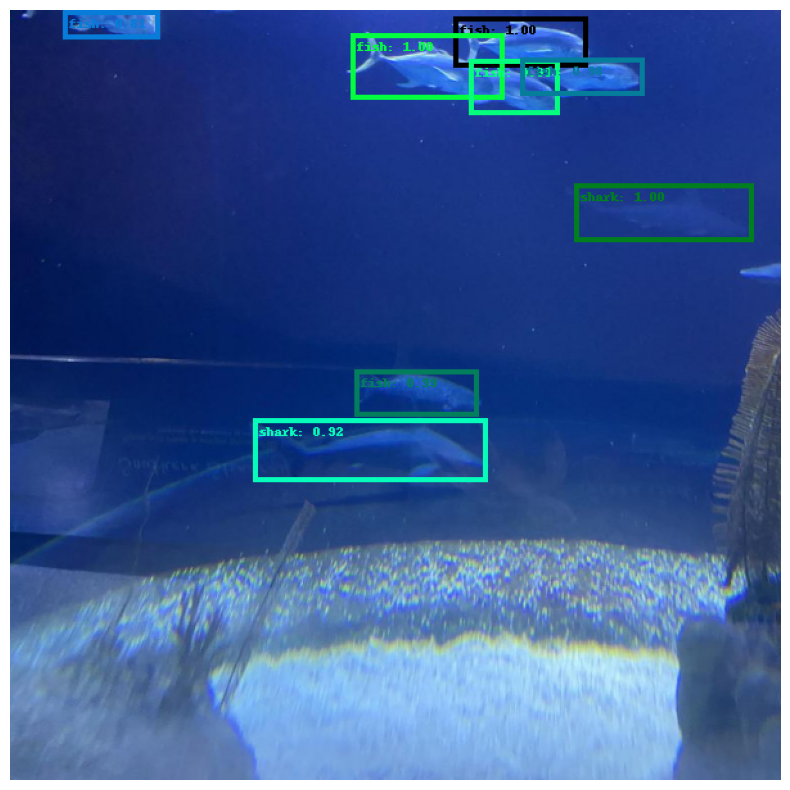

In [42]:
import matplotlib.pyplot as plt
import torch
from torchvision.ops import nms
from torchvision.utils import draw_bounding_boxes

img, _ = test_dataset[20]
img_int = torch.tensor(img * 255, dtype=torch.uint8)  
with torch.no_grad():
    prediction = model_f([img.to(device)])  
    pred = prediction[0]  

# Extract boxes, labels, and scores
boxes = pred['boxes']
labels = pred['labels']
scores = pred['scores']

# sử dụng Non-Maximum Suppression
nms_threshold = 0.3  # Threshold for IoU during NMS
keep = nms(boxes, scores, nms_threshold)  # Apply NMS

# Filter based on NMS and a minimum score threshold
min_score = 0.8
keep = keep[scores[keep] > min_score]  # Apply score filtering

# Prepare text labels with scores and class names
texts = [f'{classes[i]}: {scores[j]:.2f}' for i, j in zip(labels[keep].tolist(), keep)]

# Visualize the results
fig, ax = plt.subplots(figsize=(14, 10))
img_with_boxes = draw_bounding_boxes(img_int, boxes[keep], labels=texts, width=4)
ax.imshow(img_with_boxes.permute(1, 2, 0))
ax.axis('off')  # Hide axes
plt.show()


In [43]:
torch.save(model_f, '/kaggle/working/model_complete.pth')

# So sánh

In [44]:
from IPython.display import display, HTML
import pandas as pd

# Định nghĩa dữ liệu
data = {
    'Model': ['YOLOv8S', 'Faster R-CNN'],
    'mAP': [mAP_yolov8s, mAP]
}

# Tạo DataFrame
df_comparison = pd.DataFrame(data)

# Tạo HTML cho bảng so sánh
html = df_comparison.to_html(index=False, classes='table table-striped')

# Hiển thị bảng so sánh bằng mã HTML
display(HTML(html))
